## References
<p>This notebook is created by learning from the following notebooks:</p>
- https://github.com/minsuk-heo/kaggle-titanic/tree/master

In [1]:
import torch
from torch.utils.data import DataLoader, Dataset

## 1. Defining the problem statement
Complete the analysis of what sorts of people were likely to survive.<p>
In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

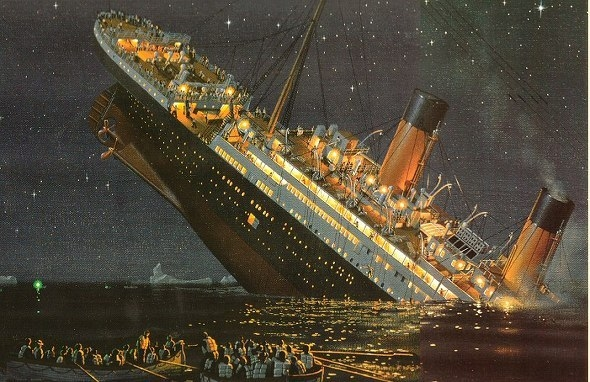

In [2]:
from IPython.display import Image
Image('./images/titanic.jpg')

## 2. Colelcting the data

load train, test dataset using Pandas

In [3]:
import pandas as pd

trainset = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

## 3. Exploratory data analysis
printing first 5 rows of the train datasets.

In [4]:
trainset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data Dictionary
- Survived : 0 = No, 1 = Yes
- Pclass : Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd
- Sibsp : # of siblings / spouses aboard the Titanic
- Parch : # of parents / children aboard the Titanic
- Ticket : Ticket number
- Cabin : Cabin number
- Embarked : Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southapotn

In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
trainset.info(), trainset.isnull().sum(), trainset.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


(None,
 PassengerId      0
 Survived         0
 Pclass           0
 Name             0
 Sex              0
 Age            177
 SibSp            0
 Parch            0
 Ticket           0
 Fare             0
 Cabin          687
 Embarked         2
 dtype: int64,
 (891, 12))

We can see that Age value is missing for many rows.<p>
Out of 891 rows, the Age value is present only in 714 rows.<p>
Similarly, Cabin values are also missing in many rows. Only 204 out of 891 rows have Cabin values.<p>

In [7]:
test.info(), test.isnull().sum(), test.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


(None,
 PassengerId      0
 Pclass           0
 Name             0
 Sex              0
 Age             86
 SibSp            0
 Parch            0
 Ticket           0
 Fare             1
 Cabin          327
 Embarked         0
 dtype: int64,
 (418, 11))

There are 177 rows with missing Age, 687 rows with missing Cabin and 2 rows with missing Embarked information.

### import python lib for visualization

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() # setting seaborn default for plots

### Bar Chart for Categorical Features
- Pclass
- Sex
- SibSp (# of siblings and spouse)
- Parch (# of parents and children)
- Embarked
- Cabin

In [9]:
def bar_chart(feature):
    # 특정 feature에 따라 분류
    survived = trainset[trainset['Survived']==1][feature].value_counts()
    dead = trainset[trainset['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived, dead])
    df.index = ['Survived', 'Dead']
    df.plot(kind='bar', stacked=True, figsize=(10, 5))

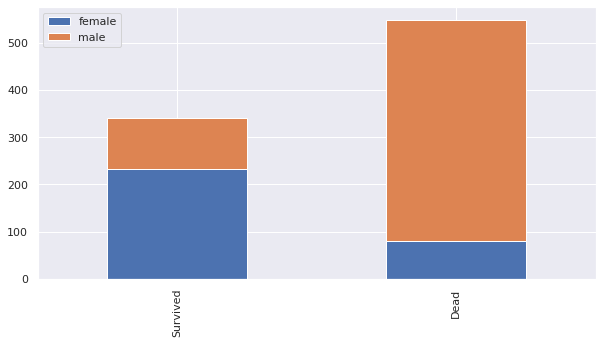

In [10]:
bar_chart('Sex')

The Chart confirms Women more likely survived than Men

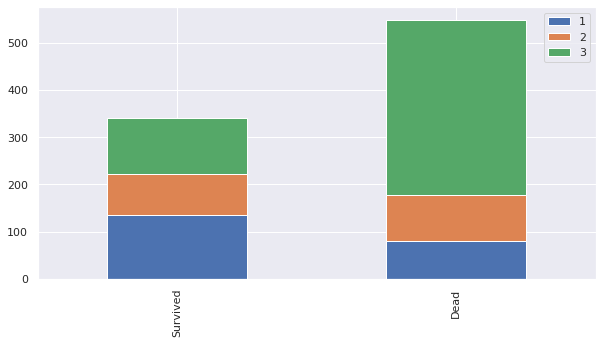

In [11]:
bar_chart('Pclass')

The Chart confirms 1st class more likely survived than other classes.<p>
The Chart confirms 3rd class more likely dead than other classes.

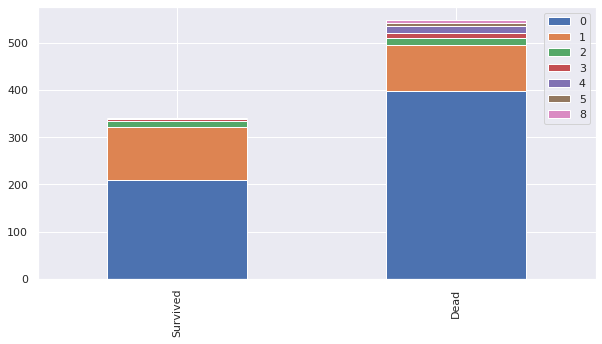

In [12]:
bar_chart('SibSp')

<p>The Chart confirms a person aboarded with more than 2 siblings or spouse more likely survived.</p>
<p>The Chart confirms a person aboarded without siblings or spouse more likely dead.</p>

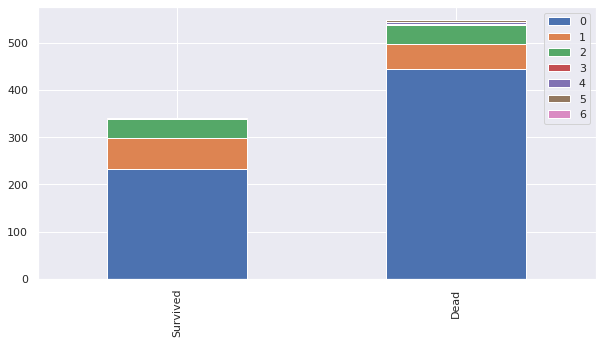

In [13]:
bar_chart('Parch')

<p>The Chart confirms a person aboarded with more than 2 parents or children more likely survived.</p>
<p>The Chart confirms ap erson aboarded alone more likely dead.</p>

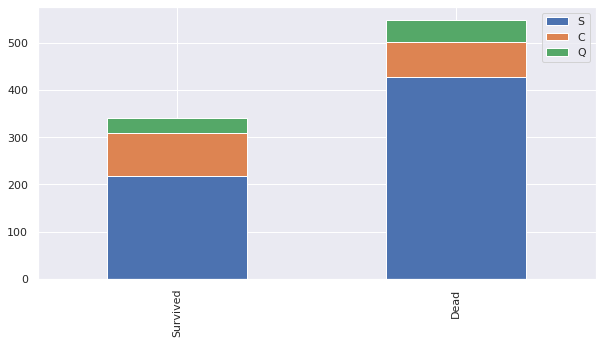

In [14]:
bar_chart('Embarked')

## 4. Feature engineering
<p>Feature engineering is the prcess of using domain knowledge of the data to create features (feature vectors) that make machine learning algorithms work.</p>
<p>Feature vector is an n-dimensional vector of numerical features that represent some object.</p>
<p> Many algorithms in machine learning require a numerical representation of objects, since such representations facilitate processing and statistical analysis.</p>
<p> remove text and NaN value.</p>

In [15]:
trainset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 4.2 Name

<p>Mr., Mrs., Miss. 등 성별, 결혼 여부 등이 생존에 영향을 끼쳤을 것으로 예측할 수 있다.</p>

In [16]:
# combining train and test dataset(묶음으로 동시에 trainset, testset에 대한 작업 가능)
train_test_data = [trainset, test]

for dataset in train_test_data:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [17]:
trainset['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Jonkheer      1
Capt          1
Don           1
Sir           1
Countess      1
Mme           1
Ms            1
Lady          1
Name: Title, dtype: int64

In [18]:
test['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dona        1
Ms          1
Dr          1
Name: Title, dtype: int64

#### Title map
<p>Mr: 0</p>
<p>Miss: 1</p>
<p>Mrs: 2</p>
<p>Others: 3</p>

In [19]:
import numpy as np

title_mapping = {'Mr': 0, 'Miss': 1, 'Mrs': 2}

for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].replace(np.nan, 3)    # Mapping 되지 않은 값은 3으로 치환

In [20]:
trainset['Title'].value_counts()

0.0    517
1.0    182
2.0    125
3.0     67
Name: Title, dtype: int64

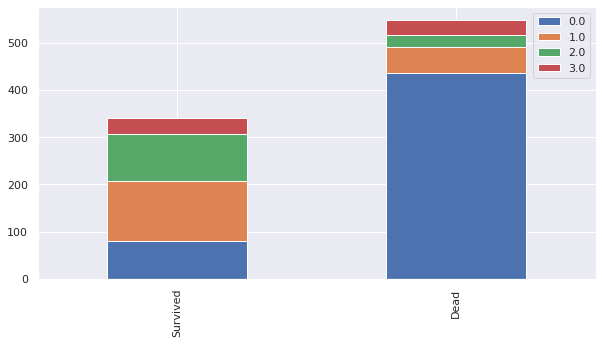

In [21]:
bar_chart('Title')

<p>Mr(0)은 많이 죽었고, Miss(1), Mrs(2)는 많이 생존한 것을 관찰할 수 있다.

In [22]:
# delete unnecessary feature from dataset
for dataset in train_test_data:
    dataset.drop('Name', axis=1, inplace=True)

In [23]:
trainset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,2.0
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,2.0
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,0.0


In [24]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,male,34.5,0,0,330911,7.8292,NaN,Q,0.0
1,893,3,female,47.0,1,0,363272,7.0000,NaN,S,2.0
2,894,2,male,62.0,0,0,240276,9.6875,NaN,Q,0.0
3,895,3,male,27.0,0,0,315154,8.6625,NaN,S,0.0
4,896,3,female,22.0,1,1,3101298,12.2875,NaN,S,2.0


#### 4.4 Sex
<p>male: 0</p>
<p>female: 1</p> 

In [25]:
sex_mapping = {'male': 0, 'female': 1}
for dataset in train_test_data:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)

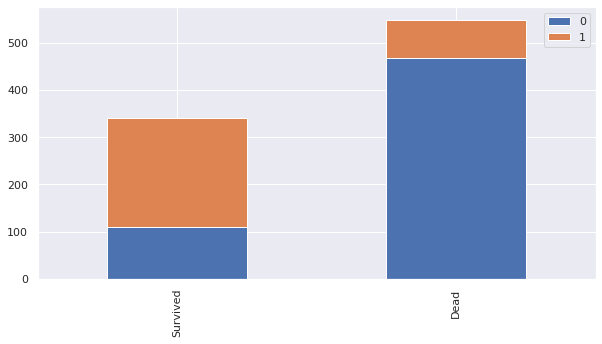

In [26]:
bar_chart('Sex')

#### 4.4 Age
<p>Let's use Title's median age for missing Age.</p>
<p>Title에 따른 중앙값으로 Age의 NaN 값을 대체한다.</p>

In [27]:
trainset.head(100)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0
1,2,1,1,1,38.0,1,0,PC 17599,71.2833,C85,C,2.0
2,3,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0
3,4,1,1,1,35.0,1,0,113803,53.1000,C123,S,2.0
4,5,0,3,0,35.0,0,0,373450,8.0500,NaN,S,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0,3,0,NaN,0,0,374910,8.0500,NaN,S,0.0
96,97,0,1,0,71.0,0,0,PC 17754,34.6542,A5,C,0.0
97,98,1,1,0,23.0,0,1,PC 17759,63.3583,D10 D12,C,0.0
98,99,1,2,1,34.0,0,1,231919,23.0000,NaN,S,2.0


In [28]:
# fill missing age with median age for each title (Mr, Mrs, Miss, Others)
for dataset in train_test_data:
    dataset['Age'].fillna(dataset.groupby('Title')['Age'].transform('median'), inplace=True)

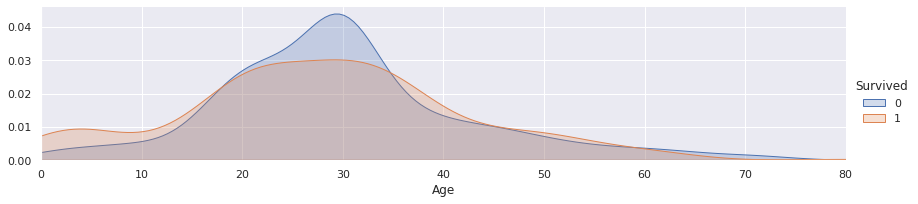

In [29]:
facet = sns.FacetGrid(trainset, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, trainset['Age'].max()))
facet.add_legend()

plt.show()

<p>어린 아이들은 생존률이 높고, 2~30대와 노년층은 생존률이 낮은 것을 관찰할 수 있다.</p>

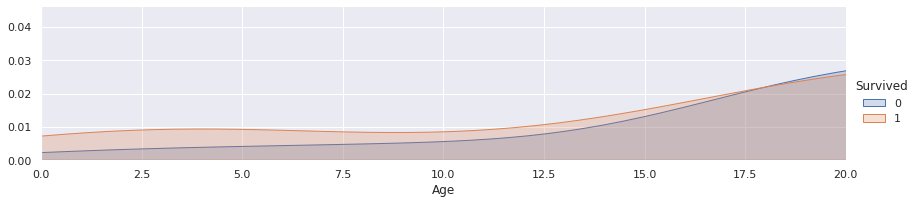

In [30]:
facet = sns.FacetGrid(trainset, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, trainset['Age'].max()))
facet.add_legend()
plt.xlim(0, 20)

plt.show()

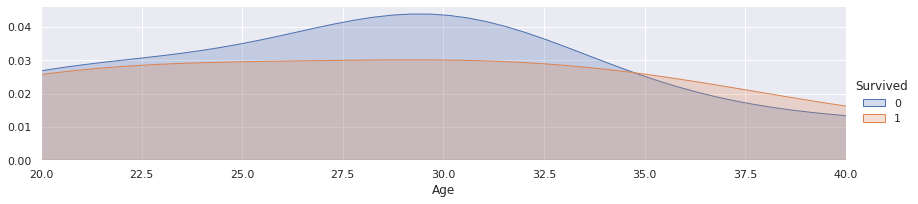

In [31]:
facet = sns.FacetGrid(trainset, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, trainset['Age'].max()))
facet.add_legend()
plt.xlim(20, 40)

plt.show()

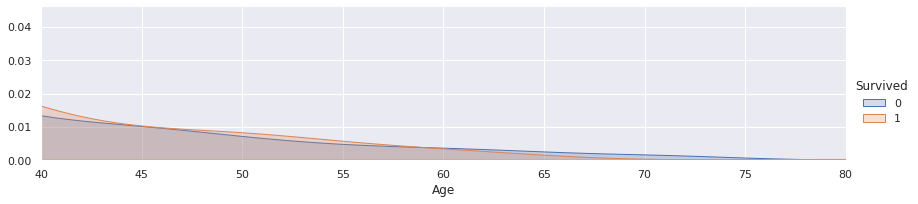

In [32]:
facet = sns.FacetGrid(trainset, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, trainset['Age'].max()))
facet.add_legend()
plt.xlim(40, trainset['Age'].max())

plt.show()

##### 4.4.2 Binning
Binning/Converting Numerical Age to Categoriacl Variable<br>
feature vector map:
- child(age<=16): 0
- young(16<age<=26): 1
- adult(26<age<=36): 2
- mid-age(36<age<=62): 3
- senior(62<age): 4



In [33]:
for dataset in train_test_data:
    dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(16 < dataset['Age']) & (dataset['Age'] <= 26), 'Age'] = 1
    dataset.loc[(26 < dataset['Age']) & (dataset['Age'] <= 36), 'Age'] = 2
    dataset.loc[(36 < dataset['Age']) & (dataset['Age'] <= 62), 'Age'] = 3
    dataset.loc[(62 < dataset['Age']), 'Age'] = 4

In [34]:
trainset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,NaN,S,0.0
1,2,1,1,1,3.0,1,0,PC 17599,71.2833,C85,C,2.0
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1.0
3,4,1,1,1,2.0,1,0,113803,53.1000,C123,S,2.0
4,5,0,3,0,2.0,0,0,373450,8.0500,NaN,S,0.0


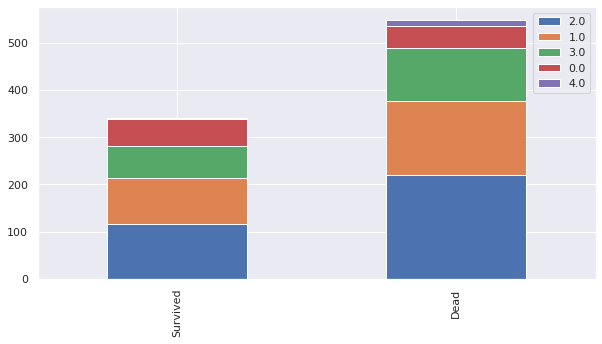

In [35]:
bar_chart('Age')

#### 4.5 Embarked<br> 
##### 4.5.1 filling missing values

<AxesSubplot:>

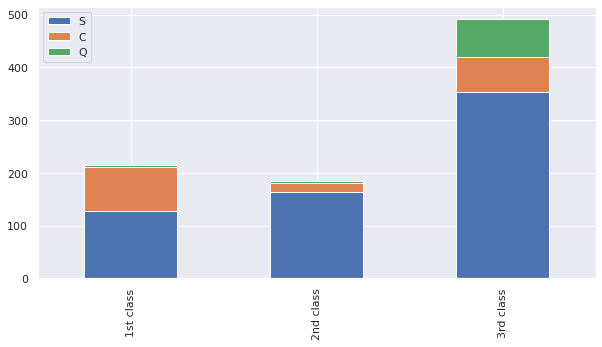

In [36]:
Pclass1 = trainset[trainset['Pclass'] == 1]['Embarked'].value_counts()
Pclass2 = trainset[trainset['Pclass'] == 2]['Embarked'].value_counts()
Pclass3 = trainset[trainset['Pclass'] == 3]['Embarked'].value_counts()
df = pd.DataFrame([Pclass1, Pclass2, Pclass3])
df.index = ['1st class', '2nd class', '3rd class']
df.plot(kind='bar', stacked=True, figsize=(10, 5))

fill out missing embark with S embark

In [37]:
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [38]:
trainset['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [39]:
embarked_mapping = {'S': 0, 'C': 1, 'Q': 2}
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

In [40]:
trainset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,NaN,0,0.0
1,2,1,1,1,3.0,1,0,PC 17599,71.2833,C85,1,2.0
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1.0
3,4,1,1,1,2.0,1,0,113803,53.1000,C123,0,2.0
4,5,0,3,0,2.0,0,0,373450,8.0500,NaN,0,0.0


#### 4.6 Fare

In [41]:
for dataset in train_test_data:
    dataset['Fare'].fillna(dataset.groupby('Pclass')['Fare'].transform('median'), inplace=True)

In [42]:
trainset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,NaN,0,0.0
1,2,1,1,1,3.0,1,0,PC 17599,71.2833,C85,1,2.0
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1.0
3,4,1,1,1,2.0,1,0,113803,53.1000,C123,0,2.0
4,5,0,3,0,2.0,0,0,373450,8.0500,NaN,0,0.0


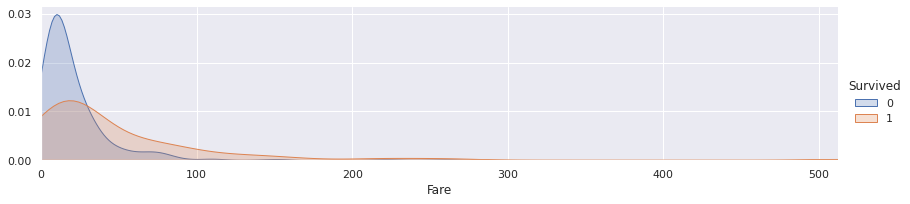

In [43]:
facet = sns.FacetGrid(trainset, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'Fare', shade=True)
facet.set(xlim=(0, trainset['Fare'].max()))
facet.add_legend()

plt.show()

싼 ticket을 구매한 사람은 사망률이 높았고, 비싼 ticket을 구매한 사람은 생존확률이 높았다.

In [44]:
for dataset in train_test_data:
    dataset.loc[dataset['Fare'] <= 17, 'Fare'] = 0
    dataset.loc[(17 < dataset['Fare']) & (dataset['Fare'] <= 30), 'Fare'] = 1
    dataset.loc[(30 < dataset['Fare']) & (dataset['Fare'] <= 100), 'Fare'] = 2
    dataset.loc[(100 < dataset['Fare']), 'Fare'] = 3

In [45]:
trainset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,1.0,1,0,A/5 21171,0.0,NaN,0,0.0
1,2,1,1,1,3.0,1,0,PC 17599,2.0,C85,1,2.0
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,0.0,NaN,0,1.0
3,4,1,1,1,2.0,1,0,113803,2.0,C123,0,2.0
4,5,0,3,0,2.0,0,0,373450,0.0,NaN,0,0.0


#### 4.7 Cabin

In [46]:
trainset.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
F2             3
C22 C26        3
              ..
E40            1
B102           1
D19            1
D37            1
D49            1
Name: Cabin, Length: 147, dtype: int64

In [47]:
for dataset in train_test_data:
    dataset['Cabin'] = dataset['Cabin'].str[:1]

<AxesSubplot:>

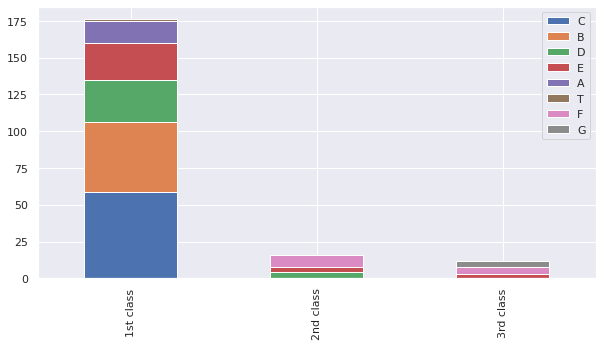

In [48]:
Pclass1 = trainset[trainset['Pclass']==1]['Cabin'].value_counts()
Pclass2 = trainset[trainset['Pclass']==2]['Cabin'].value_counts()
Pclass3 = trainset[trainset['Pclass']==3]['Cabin'].value_counts()
df = pd.DataFrame([Pclass1, Pclass2, Pclass3])
df.index = ['1st class', '2nd class', '3rd class']
df.plot(kind='bar', stacked=True, figsize=(10, 5))

In [49]:
cabin_mapping = {'A': 0, 'B': 0.4, 'C': 0.8, 'D': 1.2, 'E': 1.6, 'F': 2, 'G': 2.4, 'T': 2.8}
for dataset in train_test_data:
    dataset['Cabin'] = dataset['Cabin'].map(cabin_mapping)
    dataset['Cabin'].fillna(dataset.groupby('Pclass')['Cabin'].transform('median'), inplace=True)

#### 4.8 Family Size

In [50]:
for dataset in train_test_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

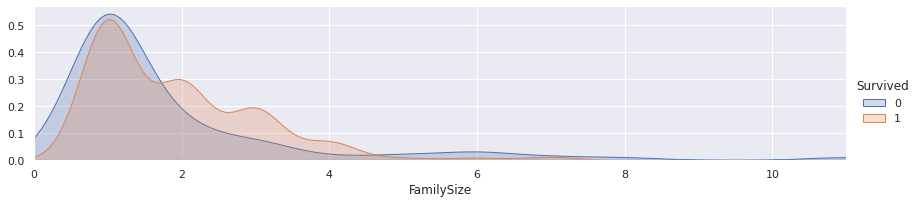

In [51]:
facet = sns.FacetGrid(trainset, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'FamilySize', shade=True)
facet.set(xlim=(0, trainset['FamilySize'].max()))
facet.add_legend()
plt.show()

In [52]:
family_mapping = {1: 0, 2: 0.4, 3: 0.8, 4: 1.2, 5: 1.6, 6: 2, 7: 2.4, 8: 2.8, 9: 3.2, 10:3.6, 11: 4}
for dataset in train_test_data:
    dataset['FamilySize'] = dataset['FamilySize'].map(family_mapping)

In [53]:
trainset['FamilySize'].value_counts()

0.0    537
0.4    161
0.8    102
1.2     29
2.0     22
1.6     15
2.4     12
4.0      7
2.8      6
Name: FamilySize, dtype: int64

In [54]:
trainset.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,1,0,3,0,1.0,1,0,A/5 21171,0.0,2.0,0,0.0,0.4
1,2,1,1,1,3.0,1,0,PC 17599,2.0,0.8,1,2.0,0.4
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,0.0,2.0,0,1.0,0.0
3,4,1,1,1,2.0,1,0,113803,2.0,0.8,0,2.0,0.4
4,5,0,3,0,2.0,0,0,373450,0.0,2.0,0,0.0,0.0
5,6,0,3,0,2.0,0,0,330877,0.0,2.0,2,0.0,0.0
6,7,0,1,0,3.0,0,0,17463,2.0,1.6,0,0.0,0.0
7,8,0,3,0,0.0,3,1,349909,1.0,2.0,0,3.0,1.6
8,9,1,3,1,2.0,0,2,347742,0.0,2.0,0,2.0,0.8
9,10,1,2,1,0.0,1,0,237736,2.0,1.8,1,2.0,0.4


In [55]:
from sklearn.model_selection import train_test_split


features_drop = ['Ticket', 'SibSp', 'Parch', 'PassengerId']

trainset = trainset.drop(features_drop, axis=1)
X_test = test.drop(features_drop, axis=1)

trainset, valset = train_test_split(trainset, test_size=0.2, random_state=1)
trainset.shape, valset.shape

((712, 9), (179, 9))

## 5. Prepare Pytorch Dataset, Model

#### 5.1 Dataset

In [56]:
class TitanicDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        if 'Survived' in data.columns:
            self.data = data.drop('Survived', axis=1).values
            self.labels = data['Survived'].values
        else:
            self.data = data.values
            self.labels = None
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.data)[idx]
        # train, val case
        if self.labels is not None:
            y = torch.LongTensor(self.labels)[idx]
            return x, y
        # predict case
        return x

In [57]:
partition = {'train':TitanicDataset(trainset), 
             'val':TitanicDataset(valset), 
             'test': TitanicDataset(X_test)}

#### 5.2 Model

Network.py 의 Net Class 에 구현

#### 5.3 Train, Val Function

utils.py에 구현

In [58]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    
    # 달라져도 서로 다른 파일이 생기는 것을 원하지 않을 때
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)    # dict를 합치기 위해서
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

### 6. Experiment

In [59]:
# Load model and functions
from Network import Net
from utils import train, validate, predict, experiment

In [60]:
import argparse
from copy import deepcopy

# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)


parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1"

# ======= Model Device ======= #
args.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# ====== Model Capacity ====== #
args.in_dim = 8
args.hid_dim = 512
args.out_dim = 2

# ====== Regularization ======= #
args.l2 = 1e-5

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 1e-4
args.epoch = 20

args.train_batch_size = 512
args.test_batch_size = 512

# ====== Experiment Variable ====== #
print(args)
net = Net(in_dim=args.in_dim, hid_dim=args.hid_dim, out_dim=args.out_dim)
setting, result, net = experiment(net, partition, deepcopy(args))

Namespace(device=device(type='cuda', index=0), epoch=20, exp_name='exp1', hid_dim=512, in_dim=8, l2=1e-05, lr=0.0001, optim='Adam', out_dim=2, test_batch_size=512, train_batch_size=512)


Epoch 0, Acc(train/val): 50.28/59.78, Loss(train/val) 0.68/0.65. Took 0.20 sec
Epoch 1, Acc(train/val): 63.62/60.89, Loss(train/val) 0.63/0.63. Took 0.19 sec
Epoch 2, Acc(train/val): 67.28/68.16, Loss(train/val) 0.59/0.60. Took 0.20 sec
Epoch 3, Acc(train/val): 74.16/69.27, Loss(train/val) 0.55/0.57. Took 0.18 sec
Epoch 4, Acc(train/val): 76.54/69.83, Loss(train/val) 0.51/0.55. Took 0.20 sec
Epoch 5, Acc(train/val): 77.25/70.39, Loss(train/val) 0.48/0.54. Took 0.19 sec
Epoch 6, Acc(train/val): 78.79/73.74, Loss(train/val) 0.45/0.54. Took 0.20 sec
Epoch 7, Acc(train/val): 81.18/75.42, Loss(train/val) 0.43/0.54. Took 0.20 sec
Epoch 8, Acc(train/val): 81.32/75.98, Loss(train/val) 0.45/0.54. Took 0.20 sec
Epoch 9, Acc(train/val): 81.88/78.21, Loss(train/val) 0.42/0.52. Took 0.20 sec
Epoch 10, Acc(train/val): 82.44/78.21, Loss(train/val) 0.39/0.51. Took 0.19 sec
Epoch 11, Acc(train/val): 83.15/77.09, Loss(train/val) 0.39/0.50. Took 0.20 sec
Epoch 12, Acc(train/val): 83.99/77.09, Loss(train/

In [61]:
prediction = predict(net, partition, args)

submission = pd.DataFrame({
    "PassengerId": test['PassengerId'],
    "Survived": prediction
})

submission.to_csv('./submission.csv', index=False)

In [62]:
submiossion = pd.read_csv('./submission.csv')
submission.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
